In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [24]:
# Завантажуємо дані
df = pd.read_csv("DailyDelhiClimateTrain.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('D') 

# Виберемо одну змінну для аналізу. Наприклад, 'meantemp'
ts = df['meantemp']


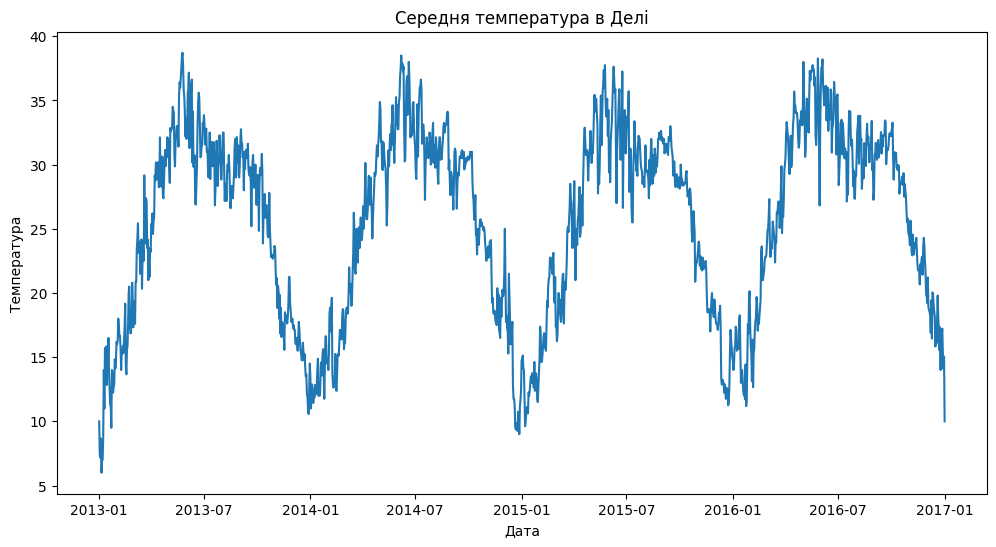

In [25]:
# Візуалізація часового ряду
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Середня температура в Делі')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.show()

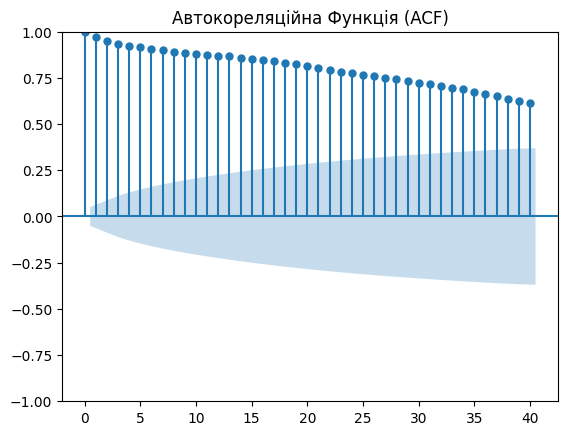

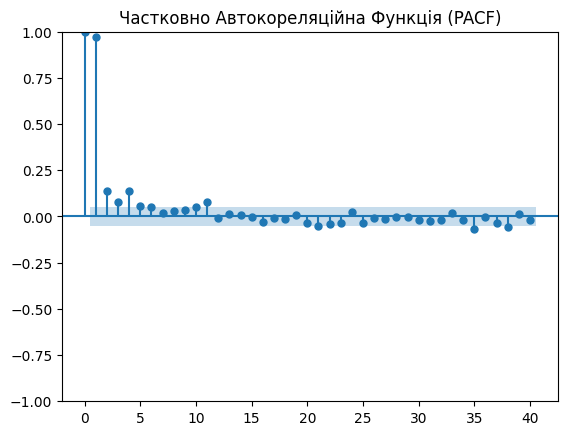

In [26]:
plot_acf(ts, lags=40)
plt.title('Автокореляційна Функція (ACF)')
plot_pacf(ts, lags=40)
plt.title('Частковно Автокореляційна Функція (PACF)')
plt.show()

In [27]:
# Перевірка стаціонарності часового ряду
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")
    
# Розділення часового ряду на тренд, сезонні та залишкові компоненти
decomposition = seasonal_decompose(ts, model='additive')
trend_component = decomposition.trend
seasonality_component = decomposition.seasonal
residuals = decomposition.resid

ADF Statistic: -2.021069
p-value: 0.277412
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Failed to Reject Ho - Time Series is Non-Stationary


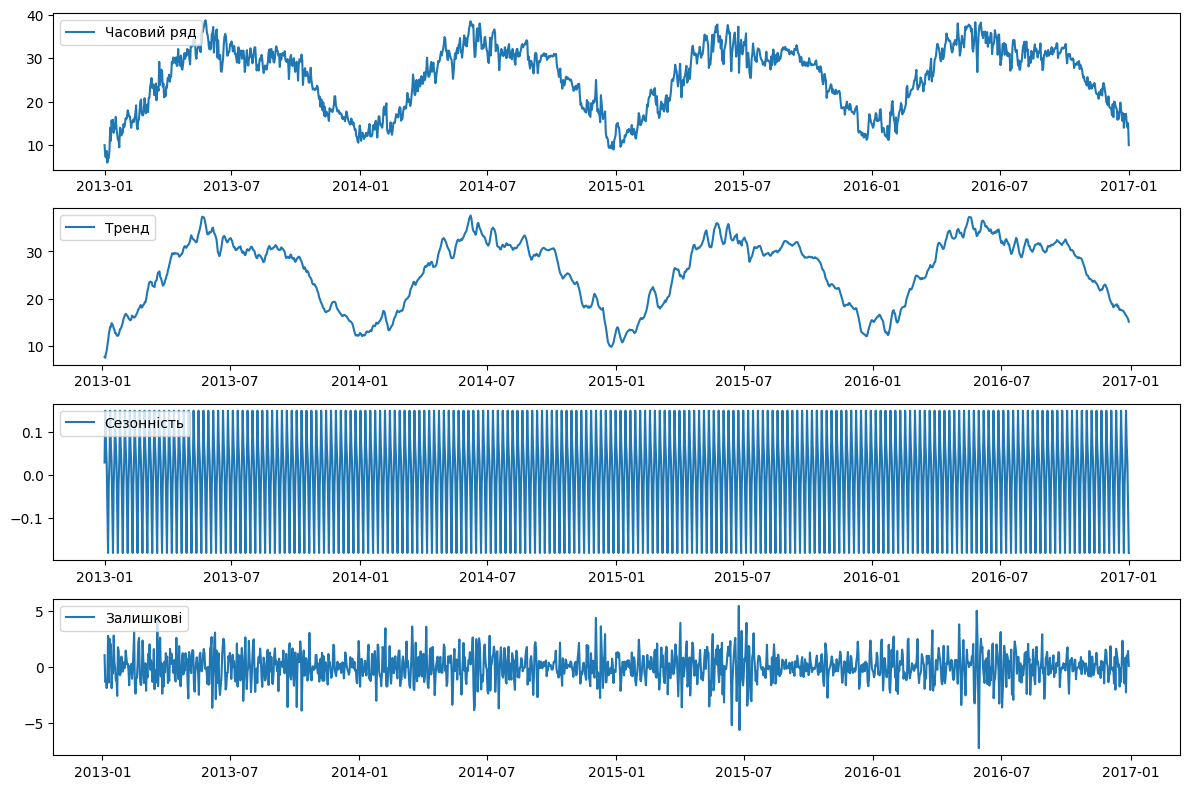

In [28]:
# Візуалізація компонентів
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts, label='Часовий ряд')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend_component, label='Тренд')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonality_component, label='Сезонність')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residuals, label='Залишкові')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [29]:
# Побудова та навчання моделі ARIMA
p, d, q = 1, 0, 0  # Параметри ARIMA
P, D, Q, s = 0, 1, 1, 7
model = SARIMAX(ts, order=(p, d, q), seasonal_order=(P, D, Q, s))

# model = sm.tsa.ARIMA(ts, order=(p, d, q))
results = model.fit()

# Прогноз на майбутні значення
forecast_steps = 100
forecasts = results.forecast(steps=forecast_steps)


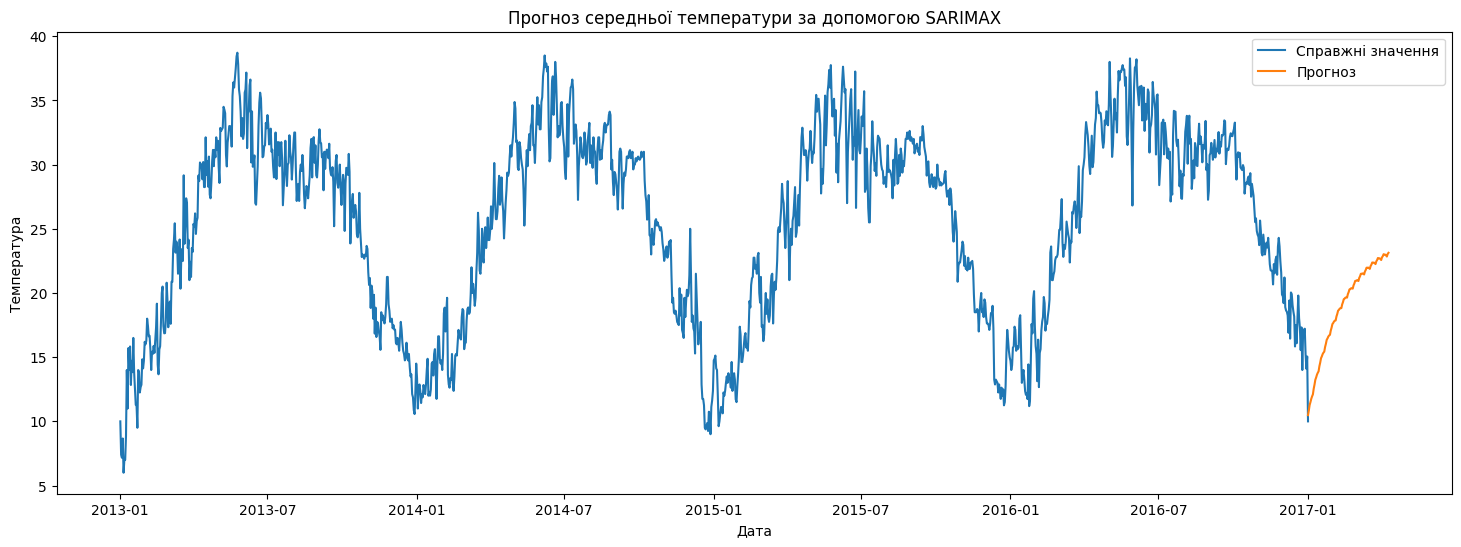

In [30]:

# Візуалізація прогнозу та реальних значень
plt.figure(figsize=(18, 6))
plt.plot(ts, label='Справжні значення')
plt.plot(pd.date_range(ts.index[-1], periods=forecast_steps), forecasts, label='Прогноз')
plt.title('Прогноз середньої температури за допомогою SARIMAX')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.show()

In [31]:
# Завантаження тестового датасету
test_data = pd.read_csv("DailyDelhiClimateTest.csv", parse_dates=['date'], index_col='date')

# Взяти перші 100 записів
test_data = test_data.head(forecast_steps)

# Переконайтеся, що індекси прогнозу та реальних даних співпадають
actual_values = test_data['meantemp'].reindex(forecasts.index)

# Обчислення помилок
mse = np.mean(np.square(forecasts - actual_values))
mae = np.mean(np.abs(forecasts - actual_values))

print(f"Середньоквадратична помилка (MSE): {mse:.2f}")
print(f"Середньоабсолютна помилка (MAE): {mae:.2f}")


Середньоквадратична помилка (MSE): 15.05
Середньоабсолютна помилка (MAE): 3.07
